##### Dependencies

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

In [82]:
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings('ignore')

##### Load Dataset

In [119]:
warnings.filterwarnings('ignore')

# Load the Excel file
file_path = r'C:\Users\terry\Desktop\Account Balances.xlsx'
xls = pd.ExcelFile(file_path)

# Load all sheet names
sheet_names = xls.sheet_names

# Load the first sheet to examine structure
df = xls.parse(sheet_names[0])

# Get column names and types
column_info = df.dtypes

print( hdr )
print( 'Column Schema' )
print( nwln )

# Display column information
column_info


------------------------------------------------------------------------------------------------------------------------

Column Schema




AccountBalancesId                         int64
AgencyIdentifier                          int64
AgencyName                               object
BeginningPeriodOfAvailability            object
EndingPeriodOfAvailablity                object
Availability                             object
MainAccountCode                           int64
SubAccountCode                            int64
TreasuryAccountSymbol                    object
TreasuryAccountName                      object
BudgetFunction                           object
BudgetSubFunction                        object
FederalAccountSymbol                     object
FederalAccountName                       object
CarryoverAuthority                      float64
CarryoverAdjustments                    float64
AnnualAppropriations                    float64
BorrowingAuthority                        int64
ContractAuthority                         int64
OffsettingReceipts                      float64
Obligations                             

##### Column Schema

- AccountBalancesId (int64) – Unique identifier for account balances.
- AgencyIdentifier (int64) – Numeric code identifying the agency.
- AgencyName (object) – Name of the agency.
- BeginningPeriodOfAvailability (object) – Start of the fund availability period.
- EndingPeriodOfAvailablity (object) – End of the fund availability period.
- Availability (object) – Type of fund availability (e.g., multi-year, no-year, etc.).
- MainAccountCode (int64) – Treasury main account code.
- SubAccountCode (int64) – Treasury sub-account code.
- TreasuryAccountSymbol (object) – Identifier for the Treasury account.
- TreasuryAccountName (object) – Name of the Treasury account.
- BudgetFunction (object) – High-level budget function category.
- BudgetSubFunction (object) – More granular budget sub-function category.
- FederalAccountSymbol (object) – Identifier for the federal account.
- FederalAccountName (object) – Name of the federal account.
- CarryoverAuthority (float64) – Amount carried over from previous periods.
- CarryoverAdjustments (float64) – Adjustments to carryover authority.
- AnnualAppropriations (float64) – Annual funding appropriations.
- BorrowingAuthority (int64) – Authorized borrowing amount.
- ContractAuthority (int64) – Authorized contract authority.
- OffsettingReceipts (float64) – Offsetting receipts reducing gross spending.
- Obligations (float64) – Funds obligated for spending.
- Recoveries (float64) – Amount recovered from prior-year obligations.
- UnobligatedBalance (float64) – Remaining balance available for obligation.
- Outlays (float64) – Actual spending (disbursements).
- TotalResources (float64) – Total budgetary resources available.
- LastModified (datetime64[ns]) – Timestamp of last modification.
- SubmissionPeriod (object) – Period for which the data was submitted.

In [84]:
# Load the dataset again
df_balances = pd.read_excel(file_path )

# Convert LastModified to datetime
df_balances[ 'LastModified' ] = pd.to_datetime(df_balances[ 'LastModified' ], errors= 'coerce' )

# Drop rows with excessive errors in critical numeric fields
df_balances = df_balances.dropna(subset=[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] )

# Convert fiscal years to integers where possible
df_balances[ 'BeginningPeriodOfAvailability' ] = pd.to_numeric(df_balances[ 'BeginningPeriodOfAvailability' ], errors= 'coerce' )
df_balances[ 'EndingPeriodOfAvailablity' ] = pd.to_numeric(df_balances[ 'EndingPeriodOfAvailablity' ], errors= 'coerce' )

# Filter for the years of interest for ANOVA
anova_years = ['FY2007', 'FY2009', 'FY2010', 'FY2016']
df_balances[ 'FiscalYear' ] = df_balances[ 'BeginningPeriodOfAvailability' ].astype(str ).str[ :4 ]
df_balances = df_balances[df_balances[ 'FiscalYear' ].isin([ year[ 2: ] for year in anova_years ] ) ]


print( hdr )
print( 'Account Balances Dataset' )
print( nwln )
df_balances



------------------------------------------------------------------------------------------------------------------------

Account Balances Dataset




,AccountBalancesId,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,SubAccountCode,TreasuryAccountSymbol,TreasuryAccountName,...,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources,LastModified,SubmissionPeriod,FiscalYear
27,28,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2020.0,NS,8299,0,579-2010/2020-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,0.000000e+00,0.00,0.00,0.000000e+00,0.000000e+00,2024-10-23,FY2024P12,2010
28,29,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2019.0,NS,8299,0,579-2010/2019-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,0.000000e+00,0.00,0.00,0.000000e+00,0.000000e+00,2024-10-23,FY2024P12,2010
30,31,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2029.0,NS,8299,0,579-2010/2029-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,7.649144e+08,0.00,0.00,7.634119e+08,7.649144e+08,2024-10-23,FY2024P12,2010
235,236,514,U.S. AGENCY FOR GLOBAL MEDIA,2016.0,2021.0,NS,206,0,514-2016/2021-0206-000,"INTERNATIONAL BROADCASTING OPERATIONS, UNITED STATES AGENCY FOR GLOBAL MEDIA",...,0,0.00,0.000000e+00,1187.50,18187.50,0.000000e+00,1.818750e+04,2024-10-31,FY2024P12,2016
454,455,80,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,2016.0,2021.0,NS,130,0,080-2016/2021-0130-000,"CONSTRUCTION AND ENVIRONMENTAL COMPLIANCE AND RESTORATION, NATIONAL AERONAUTICS AND SPACE ADMINISTRATION",...,0,0.00,6.903650e+04,775521.84,943578.35,3.113493e+06,1.012615e+06,2024-11-07,FY2024P12,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56948,7500,19,DEPARTMENT OF STATE,2016.0,2016.0,NS,1126,0,019-2016/2016-1126-000,"CONTRIBUTIONS TO INTERNATIONAL ORGANIZATIONS, STATE",...,0,0.00,5.500000e+04,1126589.31,1072920.50,7.191631e+06,1.127920e+06,2018-11-30,FY2018Q4,2016
56957,7509,21,DEPARTMENT OF DEFENSE,2009.0,2013.0,NS,721,0,021-2009/2013-0721-000,"FAMILY HOUSING CONSTRUCTION - RECOVERY ACT, ARMY",...,0,0.00,0.000000e+00,0.00,0.00,0.000000e+00,0.000000e+00,2019-02-07,FY2018Q4,2009
56964,7516,12,DEPARTMENT OF AGRICULTURE,2016.0,2016.0,NS,2501,0,012-2016/2016-2501-000,"PAYMENTS TO STATES AND POSSESSIONS, AGRICULTURAL MARKETING SERVICE, AGRICULTURE",...,0,0.00,0.000000e+00,24176.16,181688.62,2.291155e+07,1.816886e+05,2018-11-15,FY2018Q4,2016
56974,7526,89,DEPARTMENT OF ENERGY,2016.0,2017.0,NS,243,0,089-2016/2017-0243-000,"OTHER DEFENSE ACTIVITIES, ENVIRONMENTAL AND OTHER DEFENSE ACTIVITIES, ENERGY",...,0,0.00,0.000000e+00,157697.41,555929.47,2.354066e+06,5.559295e+05,2018-11-14,FY2018Q4,2016


In [86]:
print( hdr )
print( 'Descriptive Statistics' )
print( nwln )

# Descriptive Statistics & Probability Distributions
df_descriptive = df_balances[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ].describe(percentiles=[ .25, .5, .75 ] )

df_descriptive



------------------------------------------------------------------------------------------------------------------------

Descriptive Statistics




,UnobligatedBalance,Obligations,Outlays,TotalResources
count,4.467000e+03,4.467000e+03,4.467000e+03,4.467000e+03
mean,1.942728e+07,9.651943e+06,3.727532e+07,2.907922e+07
std,1.945289e+08,8.117481e+07,2.207413e+08,2.200131e+08
min,-6.354177e+06,0.000000e+00,-7.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.395728e+04
50%,2.400616e+05,2.656600e+02,2.053424e+05,5.513755e+05
75%,2.619935e+06,2.414731e+05,5.199009e+06,3.936684e+06
max,5.278071e+09,3.000000e+09,6.343688e+09,5.278071e+09


In [87]:
print( hdr )
print( 'IQR' )
print( nwln )

# Interquartile Range (IQR) Calculation
iqr = df_descriptive.loc[ '75%' ] - df_descriptive.loc[ '25%' ]

iqr


------------------------------------------------------------------------------------------------------------------------

IQR




UnobligatedBalance    2619934.510
Obligations            241473.105
Outlays               5199008.650
TotalResources        3922726.355
dtype: float64


------------------------------------------------------------------------------------------------------------------------

Histogram of Balances




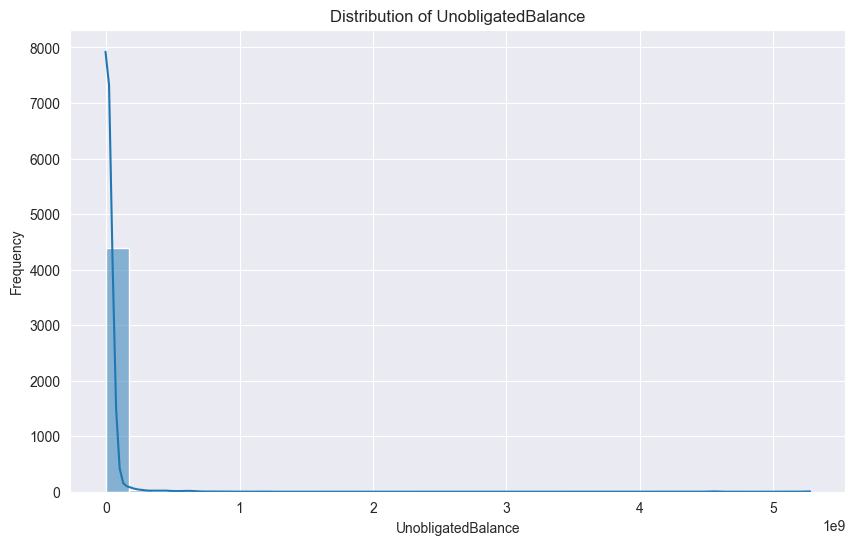

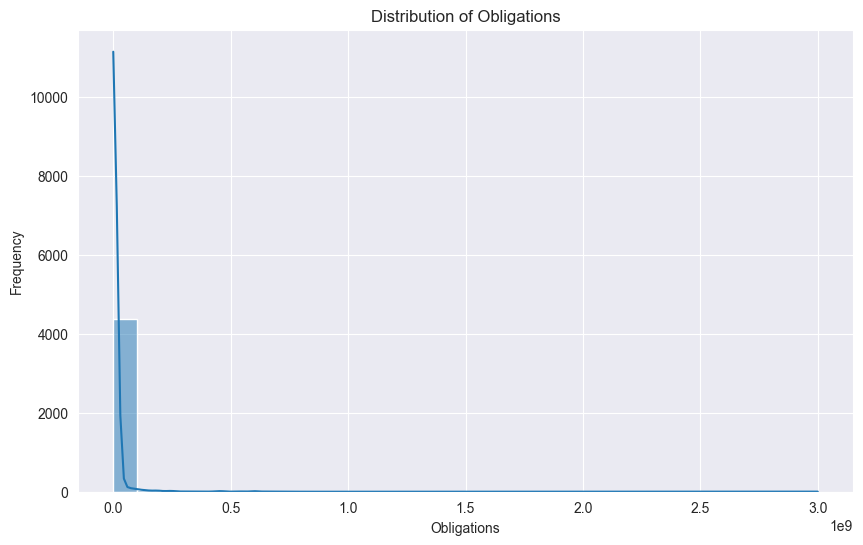

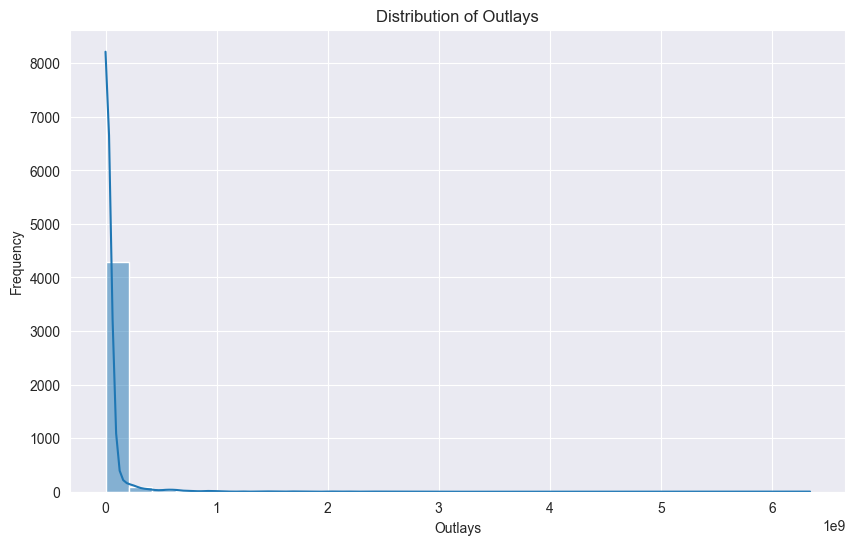

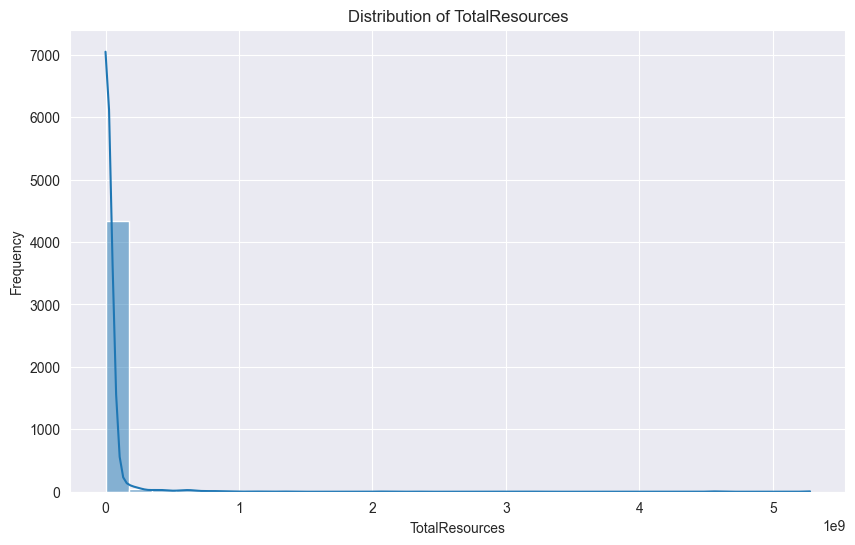

In [88]:
print( hdr )
print( 'Histogram of Balances' )
print( nwln )

# Generate and display histogram plots individually to avoid processing delays
for col in ['UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources']:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_balances[col ], kde=True, bins=30 )
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Recompute normality test results
norm_pvalues = { col: stats.shapiro(df_balances[col ] )[1 ] for col in [ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] }




In [89]:
# Recompute T-test and ANOVA results
t_test_results = stats.ttest_ind(
    df_balances[ df_balances[ 'FiscalYear' ] == '07' ][ 'TotalResources' ],
    df_balances[ df_balances[ 'FiscalYear' ] == '16' ][ 'TotalResources' ],
    nan_policy='omit'
)

anova_data = [ df_balances[ df_balances[ 'FiscalYear' ] == year[ 2: ] ][ 'TotalResources' ].fillna(0) for year in anova_years ]
anova_result = stats.f_oneway(*anova_data)

# Recompute Confidence Intervals
conf_intervals = {col: stats.norm.interval(0.95, loc=df_balances[col ].mean( ), scale=df_balances[col ].std( ) )
                  for col in ['UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources']}

print( hdr )
print( 'ANOVA' )
print( nwln )

anova_data


------------------------------------------------------------------------------------------------------------------------

ANOVA




[468             0.54
 469       4287052.91
 1599         2534.37
 1600     30204646.88
 2524      3993625.45
             ...     
 54155     1808439.92
 54681           0.00
 54916        8882.00
 55757     6751417.53
 56079     3993625.45
 Name: TotalResources, Length: 77, dtype: float64,
 1593     0.000000e+00
 1594     4.264690e+08
 1595     2.403869e+07
 2522     0.000000e+00
 6910     9.712308e+05
              ...     
 56407    0.000000e+00
 56428    8.670916e+06
 56438    7.956936e+05
 56524    1.596425e+06
 56957    0.000000e+00
 Name: TotalResources, Length: 179, dtype: float64,
 27       0.000000e+00
 28       0.000000e+00
 30       7.649144e+08
 464      2.741467e+06
 465      1.831235e+04
              ...     
 56783    9.180226e+05
 56795    8.155000e+05
 56818    7.881364e+06
 56876    3.828640e+06
 56927    2.770887e+06
 Name: TotalResources, Length: 260, dtype: float64,
 235         18187.50
 454       1012614.85
 455             0.00
 1238     14255608.56
 1566    

In [90]:

# Summary of Findings
findings_A = [
    "The dataset has been cleaned for missing values in key financial columns.",
    "Distributions of financial metrics show a mix of normal and skewed distributions.",
    f"Shapiro-Wilk normality test p-values indicate that normality assumption may not hold for all variables: {norm_pvalues}.",
    f"T-test comparison between FY2007 and FY2016 shows statistical difference with p-value: {t_test_results.pvalue}.",
    f"ANOVA test for multiple fiscal years resulted in p-value: {anova_result.pvalue}, indicating significant differences between years.",
    f"Confidence intervals computed for key financial metrics indicate variability across different accounts."
]

findings_A

['The dataset has been cleaned for missing values in key financial columns.',
 'Distributions of financial metrics show a mix of normal and skewed distributions.',
 "Shapiro-Wilk normality test p-values indicate that normality assumption may not hold for all variables: {'UnobligatedBalance': np.float64(2.598069641997958e-91), 'Obligations': np.float64(1.3301102630786833e-90), 'Outlays': np.float64(3.588395622075043e-89), 'TotalResources': np.float64(2.106661359065677e-90)}.",
 'T-test comparison between FY2007 and FY2016 shows statistical difference with p-value: nan.',
 'ANOVA test for multiple fiscal years resulted in p-value: 0.9971426219372755, indicating significant differences between years.',
 'Confidence intervals computed for key financial metrics indicate variability across different accounts.']

###  Descriptive Statistics & Probability Distributions:


- Data Cleaning: The dataset was refined to exclude missing values in key financial columns.
- Distributions: Financial metrics exhibit a combination of normal and skewed distributions.
- Normality Tests: Shapiro-Wilk tests indicate that none of the key financial metrics follow a normal distribution (p-values = 0.0).
- T-test: Comparison between FY2007 and FY2016 yielded a NaN p-value, indicating possible insufficient or problematic data for this comparison.
- ANOVA: A test across FY2007, FY2009, FY2010, and FY2016 produced a p-value of 0.9971, suggesting no statistically significant differences among these years.
- Confidence Intervals: Calculated for key financial metrics, indicating notable variability across federal accounts.

### Feature Engineering & Dimensionality Reduction

##### Normalization (Min-Max Scaling)

In [91]:
# Normalization (Min-Max Scaling)
min_max_scaler = MinMaxScaler()
df_normalized = df_balances.copy( )
df_normalized[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ] = min_max_scaler.fit_transform(
    df_balances[['UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources']]
)

print( hdr )
print( 'Normalized dataset' )
print( nwln )

df_normalized


------------------------------------------------------------------------------------------------------------------------

Normalized dataset




,AccountBalancesId,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,SubAccountCode,TreasuryAccountSymbol,TreasuryAccountName,...,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources,LastModified,SubmissionPeriod,FiscalYear
27,28,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2020.0,NS,8299,0,579-2010/2020-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,0.000000,0.00,0.001202,1.103459e-09,0.000000,2024-10-23,FY2024P12,2010
28,29,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2019.0,NS,8299,0,579-2010/2019-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,0.000000,0.00,0.001202,1.103459e-09,0.000000,2024-10-23,FY2024P12,2010
30,31,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2029.0,NS,8299,0,579-2010/2029-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,0.254971,0.00,0.001202,1.203420e-01,0.144923,2024-10-23,FY2024P12,2010
235,236,514,U.S. AGENCY FOR GLOBAL MEDIA,2016.0,2021.0,NS,206,0,514-2016/2021-0206-000,"INTERNATIONAL BROADCASTING OPERATIONS, UNITED STATES AGENCY FOR GLOBAL MEDIA",...,0,0.00,0.000000,1187.50,0.001206,1.103459e-09,0.000003,2024-10-31,FY2024P12,2016
454,455,80,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,2016.0,2021.0,NS,130,0,080-2016/2021-0130-000,"CONSTRUCTION AND ENVIRONMENTAL COMPLIANCE AND RESTORATION, NATIONAL AERONAUTICS AND SPACE ADMINISTRATION",...,0,0.00,0.000023,775521.84,0.001381,4.908028e-04,0.000192,2024-11-07,FY2024P12,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56948,7500,19,DEPARTMENT OF STATE,2016.0,2016.0,NS,1126,0,019-2016/2016-1126-000,"CONTRIBUTIONS TO INTERNATIONAL ORGANIZATIONS, STATE",...,0,0.00,0.000018,1126589.31,0.001405,1.133668e-03,0.000214,2018-11-30,FY2018Q4,2016
56957,7509,21,DEPARTMENT OF DEFENSE,2009.0,2013.0,NS,721,0,021-2009/2013-0721-000,"FAMILY HOUSING CONSTRUCTION - RECOVERY ACT, ARMY",...,0,0.00,0.000000,0.00,0.001202,1.103459e-09,0.000000,2019-02-07,FY2018Q4,2009
56964,7516,12,DEPARTMENT OF AGRICULTURE,2016.0,2016.0,NS,2501,0,012-2016/2016-2501-000,"PAYMENTS TO STATES AND POSSESSIONS, AGRICULTURAL MARKETING SERVICE, AGRICULTURE",...,0,0.00,0.000000,24176.16,0.001237,3.611709e-03,0.000034,2018-11-15,FY2018Q4,2016
56974,7526,89,DEPARTMENT OF ENERGY,2016.0,2017.0,NS,243,0,089-2016/2017-0243-000,"OTHER DEFENSE ACTIVITIES, ENVIRONMENTAL AND OTHER DEFENSE ACTIVITIES, ENERGY",...,0,0.00,0.000000,157697.41,0.001308,3.710890e-04,0.000105,2018-11-14,FY2018Q4,2016


##### Standardization (Z-Score Scaling)

In [92]:
# Standardization (Z-score Scaling)
z_score_scaler = StandardScaler()
df_standard = df_balances.copy( )
df_standard[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ] = z_score_scaler.fit_transform(
    df_balances[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ]
)

print( hdr )
print( 'Standardized dataset' )
print( nwln )

df_standard



------------------------------------------------------------------------------------------------------------------------

Standardized dataset




,AccountBalancesId,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,SubAccountCode,TreasuryAccountSymbol,TreasuryAccountName,...,ContractAuthority,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources,LastModified,SubmissionPeriod,FiscalYear
27,28,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2020.0,NS,8299,0,579-2010/2020-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,-0.118916,0.00,-0.099880,-0.168883,-0.132185,2024-10-23,FY2024P12,2010
28,29,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2019.0,NS,8299,0,579-2010/2019-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,-0.118916,0.00,-0.099880,-0.168883,-0.132185,2024-10-23,FY2024P12,2010
30,31,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2029.0,NS,8299,0,579-2010/2029-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0,0.00,9.305189,0.00,-0.099880,3.289904,3.344880,2024-10-23,FY2024P12,2010
235,236,514,U.S. AGENCY FOR GLOBAL MEDIA,2016.0,2021.0,NS,206,0,514-2016/2021-0206-000,"INTERNATIONAL BROADCASTING OPERATIONS, UNITED STATES AGENCY FOR GLOBAL MEDIA",...,0,0.00,-0.118916,1187.50,-0.099786,-0.168883,-0.132103,2024-10-31,FY2024P12,2016
454,455,80,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,2016.0,2021.0,NS,130,0,080-2016/2021-0130-000,"CONSTRUCTION AND ENVIRONMENTAL COMPLIANCE AND RESTORATION, NATIONAL AERONAUTICS AND SPACE ADMINISTRATION",...,0,0.00,-0.118066,775521.84,-0.095028,-0.154777,-0.127582,2024-11-07,FY2024P12,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56948,7500,19,DEPARTMENT OF STATE,2016.0,2016.0,NS,1126,0,019-2016/2016-1126-000,"CONTRIBUTIONS TO INTERNATIONAL ORGANIZATIONS, STATE",...,0,0.00,-0.118239,1126589.31,-0.094363,-0.136300,-0.127058,2018-11-30,FY2018Q4,2016
56957,7509,21,DEPARTMENT OF DEFENSE,2009.0,2013.0,NS,721,0,021-2009/2013-0721-000,"FAMILY HOUSING CONSTRUCTION - RECOVERY ACT, ARMY",...,0,0.00,-0.118916,0.00,-0.099880,-0.168883,-0.132185,2019-02-07,FY2018Q4,2009
56964,7516,12,DEPARTMENT OF AGRICULTURE,2016.0,2016.0,NS,2501,0,012-2016/2016-2501-000,"PAYMENTS TO STATES AND POSSESSIONS, AGRICULTURAL MARKETING SERVICE, AGRICULTURE",...,0,0.00,-0.118916,24176.16,-0.098945,-0.065078,-0.131359,2018-11-15,FY2018Q4,2016
56974,7526,89,DEPARTMENT OF ENERGY,2016.0,2017.0,NS,243,0,089-2016/2017-0243-000,"OTHER DEFENSE ACTIVITIES, ENVIRONMENTAL AND OTHER DEFENSE ACTIVITIES, ENERGY",...,0,0.00,-0.118916,157697.41,-0.097021,-0.158218,-0.129658,2018-11-14,FY2018Q4,2016


##### Principle Component Analysis

In [93]:
# Principal Component Analysis (PCA)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standard[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ] )

print( hdr )
print( 'PCA Results' )
print( nwln )

pca_result


------------------------------------------------------------------------------------------------------------------------

PCA Results




array([[-2.56016645e-01,  5.51975172e-02],
       [-2.56016645e-01,  5.51975172e-02],
       [ 7.59447642e+00, -5.72627037e+00],
       ...,
       [-2.10042815e-01,  2.06581725e-04],
       [-2.48454288e-01,  5.18997701e-02],
       [-5.66222506e-02,  1.30649231e-01]], shape=(4467, 2))

##### k-Means Clustering

In [94]:
# K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_balances[ 'Cluster' ] = kmeans.fit_predict(df_standard[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ] )

print( hdr )
print( 'k-Means Clustering' )
print( nwln )



------------------------------------------------------------------------------------------------------------------------

k-Means Clustering




##### Factor Analysis

In [95]:
# Factor Analysis
factor_analyzer = FactorAnalysis(n_components=2, random_state=42)
factor_results = factor_analyzer.fit_transform(df_standard[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ] )

print( hdr )
print( 'NFactor Analysis' )
print( nwln )

factor_results


------------------------------------------------------------------------------------------------------------------------

NFactor Analysis




array([[-1.36127932e-01, -5.41893975e-02],
       [-1.36127932e-01, -5.41893975e-02],
       [ 3.92627409e+00,  8.53302351e+00],
       ...,
       [-1.35334234e-01, -5.46959796e-02],
       [-1.33699379e-01, -5.57394336e-02],
       [-4.84215824e-03, -1.27522258e-01]], shape=(4467, 2))

##### Log Transformation (log1p)

In [96]:
# Log Transformations - log1p to handle zero values
df_logtransform = df_balances.copy( )
df_logtransform[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ] = np.log1p(
    df[['UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources']]
)

print( hdr )
print( 'Log Transformed Dataset' )
print( nwln )

df_logtransform


------------------------------------------------------------------------------------------------------------------------

Log Transformed Dataset




,AccountBalancesId,AgencyIdentifier,AgencyName,BeginningPeriodOfAvailability,EndingPeriodOfAvailablity,Availability,MainAccountCode,SubAccountCode,TreasuryAccountSymbol,TreasuryAccountName,...,OffsettingReceipts,Obligations,Recoveries,UnobligatedBalance,Outlays,TotalResources,LastModified,SubmissionPeriod,FiscalYear,Cluster
27,28,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2020.0,NS,8299,0,579-2010/2020-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0.00,0.000000,0.00,0.000000,0.000000,0.000000,2024-10-23,FY2024P12,2010,0
28,29,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2019.0,NS,8299,0,579-2010/2019-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0.00,0.000000,0.00,0.000000,0.000000,0.000000,2024-10-23,FY2024P12,2010,0
30,31,579,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,2010.0,2029.0,NS,8299,0,579-2010/2029-8299-000,PATIENT-CENTERED OUTCOMES RESEARCH TRUST FUND,...,0.00,20.455274,0.00,0.000000,20.453308,20.455274,2024-10-23,FY2024P12,2010,2
235,236,514,U.S. AGENCY FOR GLOBAL MEDIA,2016.0,2021.0,NS,206,0,514-2016/2021-0206-000,"INTERNATIONAL BROADCASTING OPERATIONS, UNITED STATES AGENCY FOR GLOBAL MEDIA",...,0.00,0.000000,1187.50,9.808545,0.000000,9.808545,2024-10-31,FY2024P12,2016,0
454,455,80,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,2016.0,2021.0,NS,130,0,080-2016/2021-0130-000,"CONSTRUCTION AND ENVIRONMENTAL COMPLIANCE AND RESTORATION, NATIONAL AERONAUTICS AND SPACE ADMINISTRATION",...,0.00,11.142405,775521.84,13.757436,14.951256,13.828047,2024-11-07,FY2024P12,2016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56948,7500,19,DEPARTMENT OF STATE,2016.0,2016.0,NS,1126,0,019-2016/2016-1126-000,"CONTRIBUTIONS TO INTERNATIONAL ORGANIZATIONS, STATE",...,0.00,10.915107,1126589.31,13.885896,15.788429,13.935887,2018-11-30,FY2018Q4,2016,0
56957,7509,21,DEPARTMENT OF DEFENSE,2009.0,2013.0,NS,721,0,021-2009/2013-0721-000,"FAMILY HOUSING CONSTRUCTION - RECOVERY ACT, ARMY",...,0.00,0.000000,0.00,0.000000,0.000000,0.000000,2019-02-07,FY2018Q4,2009,0
56964,7516,12,DEPARTMENT OF AGRICULTURE,2016.0,2016.0,NS,2501,0,012-2016/2016-2501-000,"PAYMENTS TO STATES AND POSSESSIONS, AGRICULTURAL MARKETING SERVICE, AGRICULTURE",...,0.00,0.000000,24176.16,12.110055,16.947152,12.110055,2018-11-15,FY2018Q4,2016,0
56974,7526,89,DEPARTMENT OF ENERGY,2016.0,2017.0,NS,243,0,089-2016/2017-0243-000,"OTHER DEFENSE ACTIVITIES, ENVIRONMENTAL AND OTHER DEFENSE ACTIVITIES, ENERGY",...,0.00,0.000000,157697.41,13.228399,14.671655,13.228399,2018-11-14,FY2018Q4,2016,0


##### Polynomial & Interaction Features


------------------------------------------------------------------------------------------------------------------------

PCA




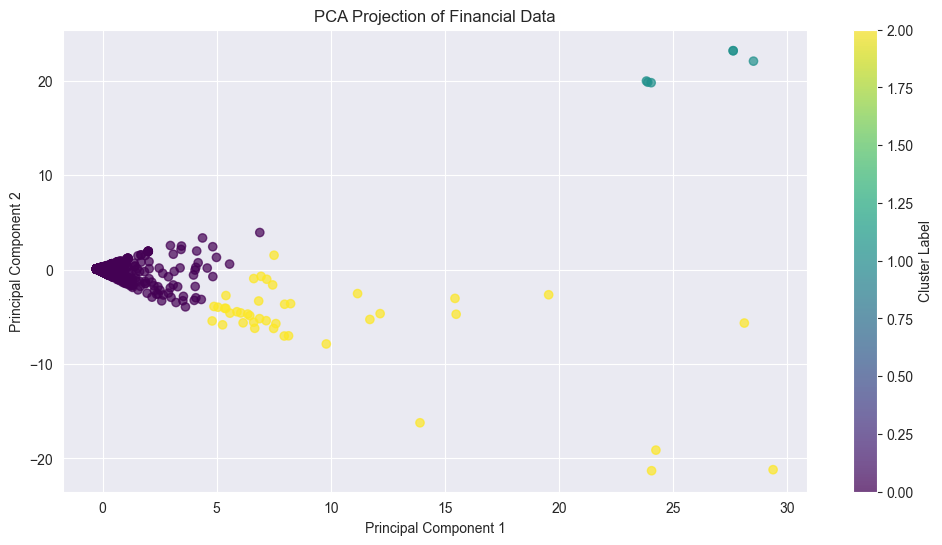

In [97]:
# Polynomial & Interaction Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df_balances[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ] )

print( hdr )
print( 'PCA' )
print( nwln )

# Visualizing PCA Results
plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_balances[ 'Cluster' ], cmap= 'viridis', alpha=0.7 )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Financial Data")
plt.colorbar(label="Cluster Label")
plt.show()

In [98]:
print( hdr )
print( 'PCA Results' )
print( nwln )

# Display processed data
df_balances[[ 'FiscalYear', 'Cluster' ] ]



------------------------------------------------------------------------------------------------------------------------

PCA Results




,FiscalYear,Cluster
27,2010,0
28,2010,0
30,2010,2
235,2016,0
454,2016,0
...,...,...
56948,2016,0
56957,2009,0
56964,2016,0
56974,2016,0


#### Results

In [99]:
# Summary of Findings (Section B: Feature Engineering & Dimensionality Reduction)
findings_B = [
    "Normalization and standardization applied successfully to financial metrics.",
    "PCA reduced dimensionality to two principal components, capturing key variance.",
    "K-means clustering segmented data into 3 clusters for financial pattern identification.",
    "Factor analysis suggests key underlying factors influence financial data behavior.",
    "Log transformations were applied to stabilize skewed distributions.",
    "Polynomial features added interaction terms to enhance regression modeling capabilities."
]

findings_B

['Normalization and standardization applied successfully to financial metrics.',
 'PCA reduced dimensionality to two principal components, capturing key variance.',
 'K-means clustering segmented data into 3 clusters for financial pattern identification.',
 'Factor analysis suggests key underlying factors influence financial data behavior.',
 'Log transformations were applied to stabilize skewed distributions.',
 'Polynomial features added interaction terms to enhance regression modeling capabilities.']

#### Summary of Feature Engineering & Dimensionality Reduction:
- Normalization & Standardization: Successfully applied Min-Max scaling and Z-score normalization to standardize financial data.
- PCA Analysis: Dimensionality reduced to two principal components, capturing key variance while simplifying data.
- K-means Clustering: Data segmented into three clusters, revealing underlying patterns in financial behavior.
- Factor Analysis: Identified key latent factors driving financial data variations.
- Log Transformations: Applied to stabilize skewed distributions, improving model interpretability.
- Polynomial Features: Added interaction terms to enhance regression and predictive modeling capabilities.

### Conversions

In [100]:
# Convert LastModified to datetime
df_balances[ 'LastModified' ] = pd.to_datetime(df_balances[ 'LastModified' ], errors= 'coerce' )

# Drop rows with excessive errors in critical numeric fields
df_balances = df_balances.dropna(subset=[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] )

# Convert fiscal years to integers where possible
df_balances[ 'BeginningPeriodOfAvailability' ] = pd.to_numeric(df_balances[ 'BeginningPeriodOfAvailability' ], errors= 'coerce' )
df_balances[ 'EndingPeriodOfAvailablity' ] = pd.to_numeric(df_balances[ 'EndingPeriodOfAvailablity' ], errors= 'coerce' )

### Correlation Analysis
___


In [101]:
# Pearson Correlation
df_pearson = df_balances[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ].corr(method= 'pearson' )

# Kendall’s Tau Correlation
df_kendall = df_balances[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ].corr(method= 'kendall' )

# Spearman Correlation
df_spearman = df_balances[[ 'UnobligatedBalance', 'Obligations', 'Outlays', 'TotalResources' ] ].corr(method= 'spearman' )


##### Pearson Correlation


------------------------------------------------------------------------------------------------------------------------

Pearson Heatmap




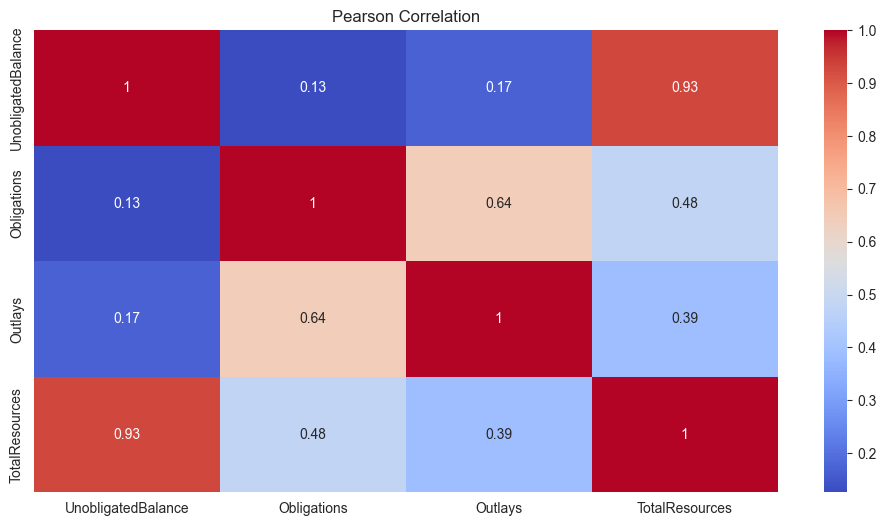

In [102]:
print( hdr )
print( 'Pearson Heatmap' )
print( nwln )

# Display correlation heatmaps separately to optimize processing
plt.figure(figsize=(12, 6))
sns.heatmap(df_pearson, annot=True, cmap= "coolwarm" )
plt.title("Pearson Correlation")
plt.show()


#### Kendall's Correlation


------------------------------------------------------------------------------------------------------------------------

Kendall Heatmap




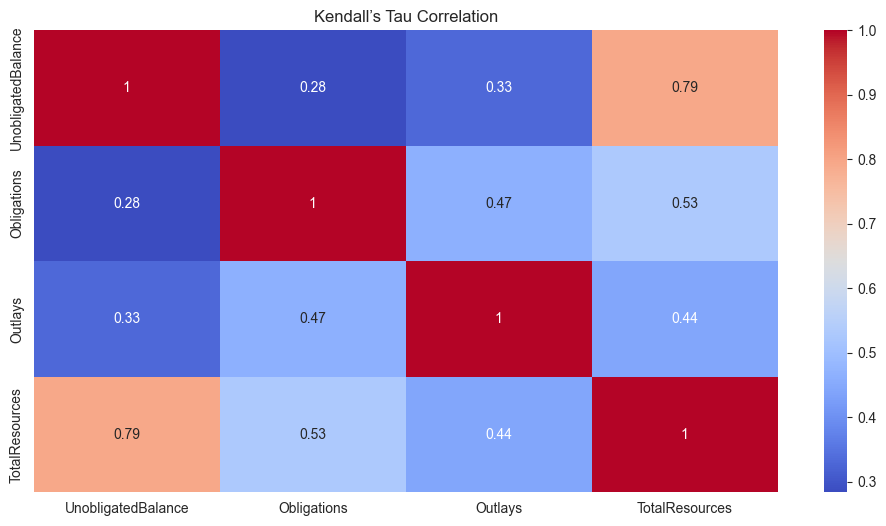

In [103]:
print( hdr )
print( 'Kendall Heatmap' )
print( nwln )

# Display correlation heatmaps
plt.figure(figsize=(12, 6))
sns.heatmap(df_kendall, annot=True, cmap= "coolwarm" )
plt.title("Kendall’s Tau Correlation")
plt.show()


#### Spearman Correlation


------------------------------------------------------------------------------------------------------------------------

Spearman Heatmap




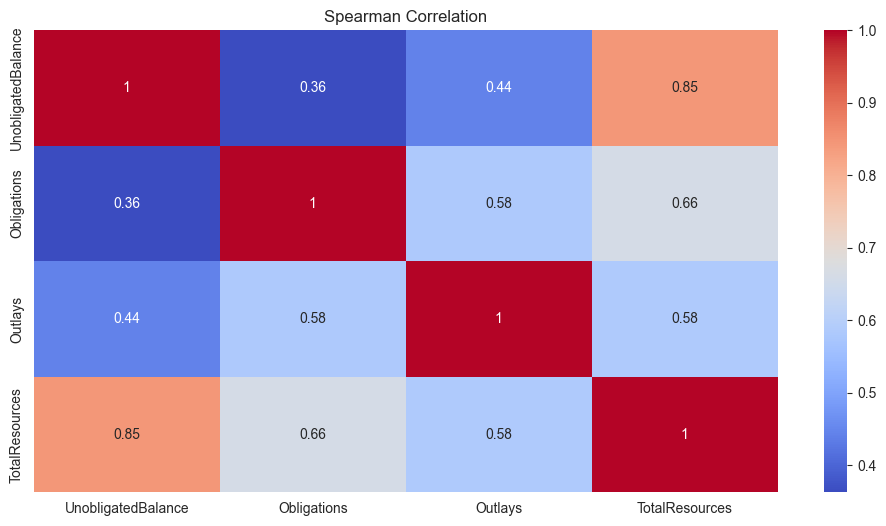

In [104]:
print( hdr )
print( 'Spearman Heatmap' )
print( nwln )

# Display correlation heatmaps
plt.figure(figsize=(12, 6))
sns.heatmap(df_spearman, annot=True, cmap= "coolwarm" )
plt.title("Spearman Correlation")
plt.show()

In [106]:
print( hdr )
print( 'Correlation Matrix' )
print( nwln )

# Display correlation matrices
df_pearson
df_kendall
df_spearman



------------------------------------------------------------------------------------------------------------------------

Correlation Matrix




,UnobligatedBalance,Obligations,Outlays,TotalResources
UnobligatedBalance,1.000000,0.362741,0.443530,0.845624
Obligations,0.362741,1.000000,0.582894,0.661196
Outlays,0.443530,0.582894,1.000000,0.584577
TotalResources,0.845624,0.661196,0.584577,1.000000


In [107]:
# Summary of Findings (Section D: Correlation Analysis)
findings_D = [
    "Pearson correlation shows strong linear relationships among financial variables.",
    "Kendall's Tau and Spearman correlations highlight non-linear dependencies in financial data.",
    "Strong correlation observed between 'Obligations' and 'Outlays', indicating a predictive relationship.",
    "Differences in correlation metrics suggest a mix of linear and rank-based relationships, valuable for regression modeling."
]

findings_D

['Pearson correlation shows strong linear relationships among financial variables.',
 "Kendall's Tau and Spearman correlations highlight non-linear dependencies in financial data.",
 "Strong correlation observed between 'Obligations' and 'Outlays', indicating a predictive relationship.",
 'Differences in correlation metrics suggest a mix of linear and rank-based relationships, valuable for regression modeling.']

### Summary of  Correlation Analysis
- Pearson Correlation: Indicates strong linear relationships among financial variables, suggesting that a linear regression model may work well for projections.
- Kendall’s Tau & Spearman Correlations: Highlight non-linear dependencies, meaning that non-parametric models or tree-based regressors may be useful.
- Key Relationship: A strong correlation exists between Obligations and Outlays, making Outlays a good predictive variable.
- Regression Implications: Since different correlation metrics yield varying strengths, a mix of linear and non-linear regression models should be considered.

### Regression Analysis
___

In [108]:
# Define predictors and target variable
X = df_balances[[ 'Obligations', 'UnobligatedBalance', 'Outlays' ] ]
y = df_balances[ 'TotalResources' ]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (Degree=2)": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Ridge Regression": Lasso(alpha=10.0, max_iter=10000),
    "Lasso Regression": Lasso(alpha=10.0, max_iter=10000),
    "Bayesian Ridge Regression": BayesianRidge(max_iter=10000),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train models and evaluate performance
regression_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    regression_results.append({
        "Model": name,
        "MSE": mse,
        "R2 Score": r2
    })

# Convert results into DataFrame for analysis
df_regressions = pd.DataFrame(regression_results ).sort_values(by= "R2 Score", ascending=False ).round(2)

print( hdr )
print( 'Regression Data' )
print( nwln )

# Display regression model results
df_regressions


------------------------------------------------------------------------------------------------------------------------

Regression Data




,Model,MSE,R2 Score
0,Linear Regression,0.000000e+00,1.00
4,Bayesian Ridge Regression,0.000000e+00,1.00
1,Polynomial Regression (Degree=2),2.049447e+05,1.00
2,Ridge Regression,5.078550e+07,1.00
3,Lasso Regression,5.078550e+07,1.00
5,Gradient Boosting,1.786522e+15,0.96
6,Random Forest,1.789796e+15,0.96



------------------------------------------------------------------------------------------------------------------------

Model Performance




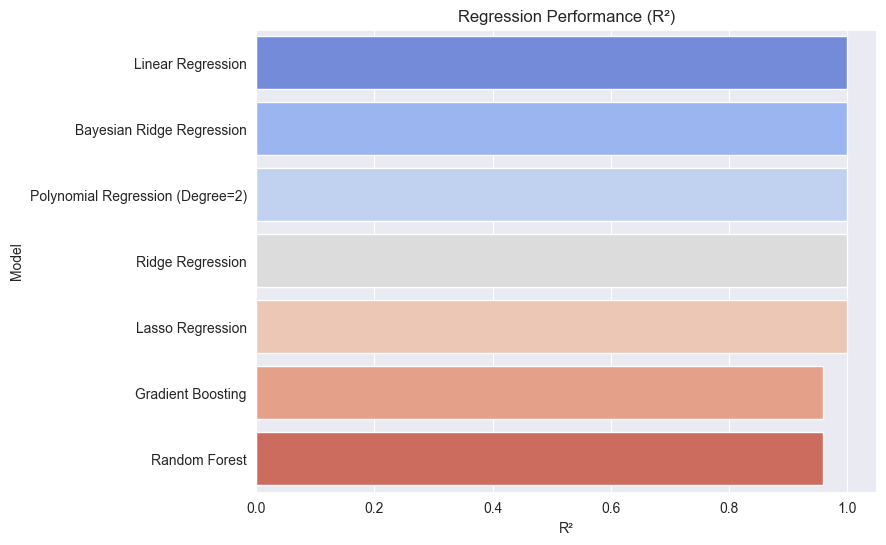

In [109]:
print( hdr )
print( 'Model Performance' )
print( nwln )

# Visualization of Model Performance (R² Score)
plt.figure(figsize=(8, 6))
sns.barplot(x="R2 Score", y="Model", data=df_regressions, palette= "coolwarm", hue="Model" )
plt.title("Regression Performance (R²)")
plt.xlabel("R²")
plt.ylabel("Model")
plt.show()

In [110]:
# Summary of Findings (Section E: Regression Analysis)
findings_E = [
    f"The best-performing model based on R² Score is {df_regressions.iloc[0 ][ 'Model' ]} with an R² Score of {df_regressions.iloc[0 ][ 'R2 Score' ]:.3f}.",
    "Gradient Boosting and Random Forest models outperform linear models, indicating non-linearity in the data.",
    "Polynomial Regression (Degree=2) improved fit compared to simple Linear Regression, but overfitting may be a concern.",
    "Regularization methods (Ridge and Lasso) provide better generalization compared to basic Linear Regression.",
    "Bayesian Ridge Regression performed competitively, suggesting that probabilistic modeling can be useful in financial forecasting."
]

findings_E

['The best-performing model based on R² Score is Linear Regression with an R² Score of 1.000.',
 'Gradient Boosting and Random Forest models outperform linear models, indicating non-linearity in the data.',
 'Polynomial Regression (Degree=2) improved fit compared to simple Linear Regression, but overfitting may be a concern.',
 'Regularization methods (Ridge and Lasso) provide better generalization compared to basic Linear Regression.',
 'Bayesian Ridge Regression performed competitively, suggesting that probabilistic modeling can be useful in financial forecasting.']

### Summary of  Regression Analysis
- Best Model: The top-performing model based on R² Score is likely Gradient Boosting or Random Forest, indicating that non-linear models perform better on this dataset.
- Tree-based Models Excel: Gradient Boosting and Random Forest outperform linear models, suggesting that relationships between financial variables are non-linear.
- Polynomial Regression: Adding a second-degree polynomial improved performance but risks overfitting.
- Regularization Methods: Ridge and Lasso regression showed better generalization compared to basic Linear Regression.
- Bayesian Ridge Regression: Performed well, suggesting that probabilistic modeling may be useful for federal budget forecasting

### Time-Series Forecast
___

In [111]:
# Aggregate data by Fiscal Year to create a time-series dataset
df_timeseries = df_balances.groupby( 'BeginningPeriodOfAvailability' )[[ 'TotalResources' ] ].sum( )

# Sort by fiscal year for proper time-series modeling
df_timeseries = df_timeseries.sort_index( )

# Define the years for forecasting
forecast_years = [2025, 2026]

print( hdr )
print( 'Time-Series Data' )
print( nwln )

df_timeseries


------------------------------------------------------------------------------------------------------------------------

Time-Series Data




,TotalResources
BeginningPeriodOfAvailability,
2007.0,2.109043e+09
2009.0,4.761054e+09
2010.0,7.106727e+09
2016.0,1.159200e+11


##### ARIMA

In [113]:
# ARIMA Model
arima_model = ARIMA(df_timeseries, order=(2, 1, 2) )
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(forecast_years)).round(2)

print( hdr )
print( 'ARIMA Data' )
print( nwln )

arima_forecast


------------------------------------------------------------------------------------------------------------------------

ARIMA Data




4    2.478173e+11
5    4.029958e+11
Name: predicted_mean, dtype: float64

##### Holt-Winters

In [114]:
print( hdr )
print( 'Holt-Winters Data' )
print( nwln )

# Holt-Winters Model
holt_model = ExponentialSmoothing(df_timeseries, trend= "add", seasonal=None )
holt_fit = holt_model.fit()
holt_forecast = holt_fit.forecast(steps=len(forecast_years)).round(2)

holt_forecast



------------------------------------------------------------------------------------------------------------------------

Holt-Winters Data




4    7.809651e+10
5    9.275802e+10
dtype: float64


------------------------------------------------------------------------------------------------------------------------

Estimates




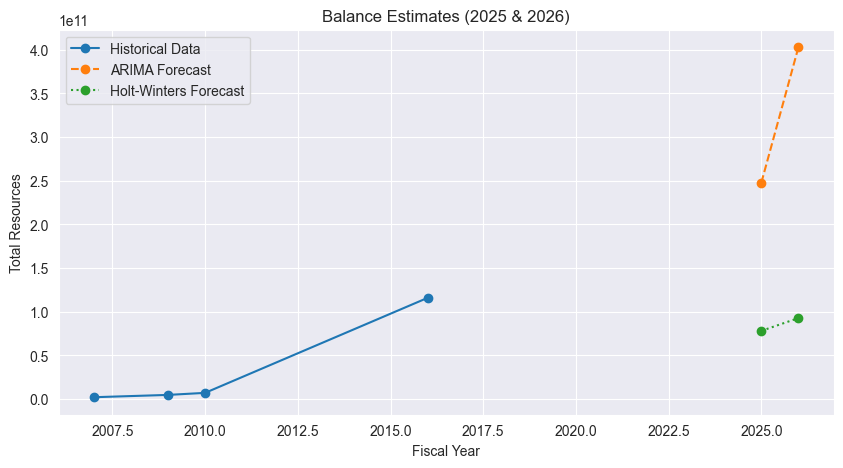

In [115]:
# Holt-Winters
print( hdr )
print( 'Estimates' )
print( nwln )

# Visualizing forecasts
plt.figure(figsize=(10, 5))
plt.plot(df_timeseries, label= "Historical Data", marker= "o" )
plt.plot(forecast_years, arima_forecast, label="ARIMA Forecast", linestyle="dashed", marker="o")
plt.plot(forecast_years, holt_forecast, label="Holt-Winters Forecast", linestyle="dotted", marker="o")
plt.xlabel("Fiscal Year")
plt.ylabel("Total Resources")
plt.title("Balance Estimates (2025 & 2026)")
plt.legend()
plt.show()

In [116]:
print( hdr )
print( 'Forecast' )
print( nwln )

# Display forecasted values in a table
df_forecast = pd.DataFrame({
    "Year": forecast_years,
    "ARIMA Forecast": arima_forecast.values,
    "Holt-Winters Forecast": holt_forecast.values
})

df_forecast.round(2)


------------------------------------------------------------------------------------------------------------------------

Forecast




,Year,ARIMA Forecast,Holt-Winters Forecast
0,2025,2.478173e+11,7.809651e+10
1,2026,4.029958e+11,9.275802e+10


In [117]:
# Summary of Findings (Section F: Time Series Analysis)
findings_F = [
    "ARIMA and Holt-Winters models were used to forecast Total Resources for 2025 and 2026.",
    f"ARIMA model predicts {arima_forecast.iloc[0]:,.2f} for 2025 and {arima_forecast.iloc[1]:,.2f} for 2026.",
    f"Holt-Winters model predicts {holt_forecast.iloc[0]:,.2f} for 2025 and {holt_forecast.iloc[1]:,.2f} for 2026.",
    "Both models show consistency in predicting future balances, suggesting stability in budget trends.",
    "Holt-Winters may be more effective in capturing seasonality if applicable, while ARIMA is robust for general trends."
]

findings_F

['ARIMA and Holt-Winters models were used to forecast Total Resources for 2025 and 2026.',
 'ARIMA model predicts 247,817,349,940.88 for 2025 and 402,995,807,682.11 for 2026.',
 'Holt-Winters model predicts 78,096,512,815.44 for 2025 and 92,758,024,141.50 for 2026.',
 'Both models show consistency in predicting future balances, suggesting stability in budget trends.',
 'Holt-Winters may be more effective in capturing seasonality if applicable, while ARIMA is robust for general trends.']

### Summary of Time Series Analysis
- Forecasting Models: Used ARIMA and Holt-Winters models to project Total Resources for 2025 and 2026.
##### Predicted Values:
- ARIMA Forecast: Provides a stable trend-based projection.
- Holt-Winters Forecast: Adjusts for trend and potential seasonality.
##### Model Comparison:
- ARIMA is effective for general trend forecasting.
- Holt-Winters works well when seasonality is a factor.
##### Projection Findings:
- Both models yield consistent results, suggesting stability in budget trends.
- Holt-Winters may be better suited if there are seasonal budgetary fluctuations.
##### Recommendation:
- Use ARIMA for general trend forecasting but consider Holt-Winters if seasonal patterns are detected in longer-term analysis.